In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os, shutil
# from data import FaceScrub, CelebA
from model import Classifier, Inversion
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import copy
import time
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from PIL import Image

In [3]:
import torch
from torchvision import transforms, datasets

In [4]:
output_path = './results/deep'
os.makedirs(output_path, exist_ok=True)

In [5]:
# data_transform = transforms.Compose([
#         transforms.Grayscale(),
#         transforms.Resize(64),
#         transforms.ToTensor()
#     ])

# test_dataset = datasets.ImageFolder(root='.\\data\\celeba_108',
#                                            transform=data_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                              batch_size=4, shuffle=False,
#                                              num_workers=0)

In [6]:
# for i_batch, sample_batched in enumerate(test_loader):
#     print(i_batch)
#     print(sample_batched[0].shape,sample_batched[1].shape)
    
# #     batch_size = sample_batched[0].size(0)
# #     im_size = sample_batched[0].size(2)
# #     grid_border_size = 2

#     grid = utils.make_grid(sample_batched[0])
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
#     break

In [7]:
class CelebA(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        data = []
        for i in range(1):
            data.append(np.load(os.path.join(self.root, 'celebA_64_64.npy')))
        data = np.concatenate(data, axis=0)

#         v_min = data.min(axis=0)
#         v_max = data.max(axis=0)
#         data = (data - v_min) / (v_max - v_min)
        labels = np.array([0] * len(data))

        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [8]:
# Training settings
parser = argparse.ArgumentParser(description='Adversarial Model Inversion Demo')
parser.add_argument('--batch-size', type=int, default=128, metavar='')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='')
parser.add_argument('--epochs', type=int, default=1, metavar='')
parser.add_argument('--lr', type=float, default=0.01, metavar='')
parser.add_argument('--momentum', type=float, default=0.5, metavar='')
parser.add_argument('--no-cuda', action='store_true', default=False)
parser.add_argument('--seed', type=int, default=1, metavar='')
parser.add_argument('--log-interval', type=int, default=10, metavar='')
parser.add_argument('--nc', type=int, default=1)
parser.add_argument('--ndf', type=int, default=128)
parser.add_argument('--ngf', type=int, default=128)
parser.add_argument('--nz', type=int, default=530)
parser.add_argument('--truncation', type=int, default=530)
parser.add_argument('--c', type=float, default=50.)
parser.add_argument('--num_workers', type=int, default=0, metavar='')

_StoreAction(option_strings=['--num_workers'], dest='num_workers', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar='')

In [9]:
def train(classifier, inversion, log_interval, device, data_loader, optimizer, epoch):
    classifier.eval()
    inversion.train()

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            prediction = classifier(data, release=True)
        reconstruction = inversion(prediction)
        loss = F.mse_loss(reconstruction, data)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data),
                                                                  len(data_loader.dataset), loss.item()))

def test(classifier, inversion, device, data_loader, epoch, msg):
    classifier.eval()
    inversion.eval()
    mse_loss = 0
    plot = True
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            prediction = classifier(data, release=True)
            reconstruction = inversion(prediction)
            mse_loss += F.mse_loss(reconstruction, data, reduction='sum').item()

            if plot:
                truth = data[0:32]
                inverse = reconstruction[0:32]
                out = torch.cat((inverse, truth))
                for i in range(4):
                    out[i * 16:i * 16 + 8] = inverse[i * 8:i * 8 + 8]
                    out[i * 16 + 8:i * 16 + 16] = truth[i * 8:i * 8 + 8]
                vutils.save_image(out, '{}/recon_{}_{}.png'.format(output_path, msg.replace(" ", ""), epoch), normalize=False)
                plot = False

    mse_loss /= len(data_loader.dataset) * 64 * 64
    print('\nTest inversion model on {} set: Average MSE loss: {:.6f}\n'.format(msg, mse_loss))
    return mse_loss

In [10]:
args = parser.parse_args(['--num_workers', '0'])
print("================================")
print(args)
print("================================")

#os.makedirs('out', exist_ok=True)

use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': args.num_workers, 'pin_memory': True} if use_cuda else {}

torch.manual_seed(args.seed)

# transform = transforms.Compose([transforms.ToTensor()])
# train_set = CelebA('./data/celebA', transform=transform)
# Inversion attack on TRAIN data of facescrub classifier
# test1_set = FaceScrub('./data/facescrub', transform=transform, train=True)
# Inversion attack on TEST data of facescrub classifier
# test2_set = FaceScrub('./data/facescrub', transform=transform, train=False)

facescrub_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(64),
        transforms.ToTensor()
    ])
celeba_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(64),
        transforms.ToTensor()
    ])

train_set = datasets.ImageFolder(root='./data/celeba_108',
                                           transform=celeba_transform)
# CelebA('.\\data\\celeba_64', transform=celeba_transform)
test1_set = datasets.ImageFolder(root='./data/150x150/train',
                                           transform=facescrub_transform)
test2_set = datasets.ImageFolder(root='./data/150x150/validate',
                                           transform=facescrub_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True, **kwargs)
test1_loader = torch.utils.data.DataLoader(test1_set, batch_size=args.test_batch_size, shuffle=False, **kwargs)
test2_loader = torch.utils.data.DataLoader(test2_set, batch_size=args.test_batch_size, shuffle=False, **kwargs)

classifier = nn.DataParallel(Classifier(nc=args.nc, ndf=args.ndf, nz=args.nz)).to(device)
inversion = nn.DataParallel(Inversion(nc=args.nc, ngf=args.ngf, nz=args.nz, truncation=args.truncation, c=args.c)).to(device)
optimizer = optim.Adam(inversion.parameters(), lr=0.0002, betas=(0.5, 0.999), amsgrad=True)

# Load classifier
path = f'{output_path}/classifier.pth'
try:
    checkpoint = torch.load(path)
    classifier.load_state_dict(checkpoint['model'])
    epoch = checkpoint['epoch']
    best_cl_acc = checkpoint['best_cl_acc']
    print("=> loaded classifier checkpoint '{}' (epoch {}, acc {:.4f})".format(path, epoch, best_cl_acc))
except:
    print("=> load classifier checkpoint '{}' failed".format(path))
    
path = f'{output_path}/inversion.pth'
try:
    checkpoint = torch.load(path)
    inversion.load_state_dict(checkpoint['model'])
    epoch = checkpoint['epoch']
    best_recon_loss = checkpoint['best_recon_loss']
    print("=> loaded classifier checkpoint '{}' (epoch {}, best_recon_loss {:.4f})".format(path, epoch, best_recon_loss))
except:
    print("=> load classifier checkpoint '{}' failed".format(path))

Namespace(batch_size=128, c=50.0, epochs=1, log_interval=10, lr=0.01, momentum=0.5, nc=1, ndf=128, ngf=128, no_cuda=False, num_workers=0, nz=530, seed=1, test_batch_size=128, truncation=530)
=> loaded classifier checkpoint './results/deep/classifier.pth' (epoch 99, acc 0.8579)
=> loaded classifier checkpoint './results/deep/inversion.pth' (epoch 76, best_recon_loss 0.0091)


In [11]:
inversion

DataParallel(
  (module): Inversion(
    (decoder): Sequential(
      (0): ConvTranspose2d(530, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Tanh()
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Tanh()
      (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (13): Sigmoid()
    )
  )
)

In [12]:
# test1_set
pcc_indices = []
current_label = -1
for i, target in enumerate(test2_set.targets):
    if target > current_label:
        current_label = target
        pcc_indices.append(i)

pcc_dataset = torch.utils.data.Subset(test2_set, pcc_indices)
pcc_loader = torch.utils.data.DataLoader(pcc_dataset, batch_size=args.batch_size)
print(len(pcc_dataset))

526


## Add bit error and collect metrics

In [13]:
output_path = './results/deep'
os.makedirs(output_path, exist_ok=True)
baseacc_file = 'baseacc.csv'
basepcc_file = 'basepcc.csv'
biterror2acc_file = 'biterror2acc.csv'
biterror2pcc_file = 'biterror2pcc.csv'

test_n = 1
baseacc = pd.DataFrame(columns=['acc'])
basepcc = pd.DataFrame(columns=['idx','target','pcc'])
biterror2acc = pd.DataFrame(columns=['test','biterror1','biterror2','acc'])
biterror2pcc = pd.DataFrame(columns=['test','biterror1','biterror2','idx','target','pcc'])

In [14]:
def classifier_test(classifier, device, data_loader):
    classifier.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)
    print('\nTest classifier: Average loss: {:.6f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))
    return correct / len(data_loader.dataset)


def calculate_pcc(classifier, inversion, device, data_loader, basepcc):
    classifier.eval()
    inversion.eval()
    mse_loss = 0
    plot = True
    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            data = data.to(device)
            prediction = classifier(data, release=True)
            reconstruction = inversion(prediction)
            # mse_loss += F.mse_loss(reconstruction, data, reduction='sum').item()
            
            vdata = data - torch.mean(data)
            vreconstruction = reconstruction - torch.mean(reconstruction)
            pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))
            
            basepcc = basepcc.append({'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)
            
    # mse_loss /= len(data_loader.dataset) * 64 * 64
    # print('\nTest inversion model on {} set: Average MSE loss: {:.6f}\n'.format(msg, mse_loss))
    return basepcc


if os.path.exists(f'{output_path}/{baseacc_file}'):
    baseacc = pd.read_csv(f'{output_path}/{baseacc_file}')
else:
    tmpacc = classifier_test(classifier, device, test2_loader) # IMPORTANT: send dataloader (not dataset)
    baseacc = baseacc.append({'acc': tmpacc}, ignore_index=True)
    baseacc.to_csv(f'{output_path}/{baseacc_file}', index=False)
    
if os.path.exists(f'{output_path}/{basepcc_file}'):
    basepcc = pd.read_csv(f'{output_path}/{basepcc_file}')
else:
    basepcc = calculate_pcc(classifier, inversion, device, pcc_dataset, basepcc) # IMPORTANT: send dataset instead of dataloader
    basepcc.to_csv(f'{output_path}/{basepcc_file}', index=False)

In [15]:
classifier

DataParallel(
  (module): Classifier(
    (encoder): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): ReLU(inplace=True)
      (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(

In [16]:
conv1w = copy.deepcopy(classifier.module.encoder[0].weight.data)
conv1b = copy.deepcopy(classifier.module.encoder[0].bias.data[:])
conv2w = copy.deepcopy(classifier.module.encoder[4].weight.data)
conv2b = copy.deepcopy(classifier.module.encoder[4].bias.data[:])
conv3w = copy.deepcopy(classifier.module.encoder[8].weight.data)
conv3b = copy.deepcopy(classifier.module.encoder[8].bias.data[:])
conv4w = copy.deepcopy(classifier.module.encoder[12].weight.data)
conv4b = copy.deepcopy(classifier.module.encoder[12].bias.data[:])

In [17]:
ww1 = copy.deepcopy(classifier.module.fc[0].weight.data)
bb1 = copy.deepcopy(classifier.module.fc[0].bias.data[:])
ww2 = copy.deepcopy(classifier.module.fc[2].weight.data)
bb2 = copy.deepcopy(classifier.module.fc[2].bias.data[:])

In [18]:
def float2bin_gpu(f, fixed_exp, nbits=8):
    s = torch.sign(f)
    f = f * s
    s = (s * (-1) + 1.) * 0.5
    s= s.unsqueeze(-1)
    f = f/(2**fixed_exp)
    m = integer2bit(f - f % 1,num_bits = nbits-1)
    dtype = f.type()
    out = torch.cat([s, m], dim=-1).type(dtype)
    return out

def integer2bit(integer, num_bits=7):
    dtype = integer.type()
    exponent_bits = -torch.arange(-(num_bits - 1), 1).type(dtype)
    exponent_bits = exponent_bits.repeat(integer.shape + (1,))
    out = integer.unsqueeze(-1) / 2 ** exponent_bits
    return (out - (out % 1)) % 2

def bin2float_gpu(b, fixed_exp, nbits=8):
    dtype = torch.float32
    s = torch.index_select(b, -1, torch.arange(0, 1).to(device))
    m = torch.index_select(b, -1, torch.arange(1,nbits).to(device))
    out = ((-1) ** s).squeeze(-1).type(dtype)
    exponents = -torch.arange(-(nbits - 2.), 1.).to(device)
    exponents = exponents.repeat(b.shape[:-1] + (1,))
    e_decimal = torch.sum(m * 2 ** (exponents), dim=-1)
    out *= e_decimal * 2 ** fixed_exp
    return out

def bin_add_bit_error(b, bit_error_percent = 0):
    cond = torch.rand(b.shape).to(device) > bit_error_percent
    a = 1 - b
    out = cond * b + torch.logical_not(cond) * a
    return out

# evauluation: make sure the conversion functions work correctly
nbits = 12
f = ww1
weight_max = torch.max(f)
fixed_exp = torch.ceil(torch.log2(weight_max/(2**(nbits-1)-1))) + 1
# rec = bin2float_gpu(float2bin_gpu(f, fixed_exp, nbits),fixed_exp, nbits)
# if not torch.all((rec - f) <= 1 * 2**fixed_exp):
#     print(i, 'binary float conversion failed')
# if not torch.all(rec - f >= -1 * 2**fixed_exp):
#     print(i, 'binary float conversion failed')

In [19]:
# set bit error list
# bit_error_percent_list = np.logspace(-4,-10,7,base=2)
# bit_error_percent_list = sorted(np.append(bit_error_percent_list, [np.logspace(-5,-7,3,base=2) * 4 / 3, np.logspace(-5,-7,3,base=2) * 5 / 3]))
# bit_error_percent_list = np.append(bit_error_percent_list,0.07)
bit_error_percent_list = []
bit_error_n = len(bit_error_percent_list)
print(bit_error_percent_list, bit_error_n)

[] 0


In [20]:
if os.path.exists(f'{output_path}/{biterror2acc_file}'):
    biterror2acc = pd.read_csv(f'{output_path}/{biterror2acc_file}')
if os.path.exists(f'{output_path}/{biterror2pcc_file}'):
    biterror2pcc = pd.read_csv(f'{output_path}/{biterror2pcc_file}')
    

for ntest in range(5,10):
    for num1, biterror1 in enumerate(bit_error_percent_list):
        # for num2, biterror2 in enumerate(bit_error_percent_list):
        num2, biterror2 = num1, biterror1
        start_time = time.time() 

        # introducing errors
        for i in range(ww1.size()[0]):
            f = ww1[i]
            f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror1), fixed_exp, nbits)
            classifier.module.fc[0].weight.data[i] = f_modify

        for i in range(bb1.size()[0]):
            f = bb1[i]
            f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror1), fixed_exp, nbits)
            classifier.module.fc[0].bias.data[i] = f_modify

        for i in range(ww2.size()[0]):
            f = ww2[i]
            f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror2), fixed_exp, nbits)
            classifier.module.fc[2].weight.data[i] = f_modify

        for i in range(bb2.size()[0]):
            f = bb2[i]
            f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror2), fixed_exp, nbits)
            classifier.module.fc[2].bias.data[i] = f_modify

        # get accuracy for modified network
        tmpacc = classifier_test(classifier, device, test2_loader)
        biterror2acc = biterror2acc.append({'test': ntest, 'biterror1': biterror1, 'biterror2': biterror2, 'acc': tmpacc}, ignore_index=True)

        # get pcc similarity for modified network
        classifier.eval()
        inversion.eval()
        with torch.no_grad():
            for i, (data, target) in enumerate(pcc_dataset):
                data = data.to(device)
                prediction = classifier(data, release=True)
                reconstruction = inversion(prediction)

                vdata = data - torch.mean(data)
                vreconstruction = reconstruction - torch.mean(reconstruction)
                pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))

                biterror2pcc = biterror2pcc.append({'test': ntest,'biterror1':biterror1,'biterror2':biterror2,'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)

        end_time = time.time()
        print("time:", end_time-start_time)

        biterror2acc.to_csv(f'{output_path}/{biterror2acc_file}', index=False)
        biterror2pcc.to_csv(f'{output_path}/{biterror2pcc_file}', index=False)

In [21]:
basepcc['pcc'].mean()

0.8852220505192167

In [22]:
biterror2pcc[biterror2pcc['biterror1'] == biterror2pcc['biterror2']].groupby(['biterror1'])['pcc'].mean()
# biterror2pcc

biterror1
0.000977    0.876092
0.001953    0.866436
0.003906    0.848531
0.007812    0.804593
0.010417    0.778143
0.013021    0.734442
0.015625    0.700617
0.020833    0.624077
0.026042    0.549211
0.031250    0.467411
0.041667    0.395315
0.052083    0.349003
0.062500    0.307954
0.070000    0.305876
Name: pcc, dtype: float64

In [23]:
biterror2acc[biterror2acc['biterror1'] == biterror2acc['biterror2']].groupby(['biterror1'])['acc'].mean()
# biterror2acc

biterror1
0.000977    0.854948
0.001953    0.852249
0.003906    0.845283
0.007812    0.833333
0.010417    0.827105
0.013021    0.817232
0.015625    0.810980
0.020833    0.799193
0.026042    0.783599
0.031250    0.776655
0.041667    0.753610
0.052083    0.737878
0.062500    0.723691
0.070000    0.718616
Name: acc, dtype: float64

## Add Gaussian noise

In [24]:
# gaussian_level_list = [0.003, 0.006, 0.009, 0.012]
# for i in range(13,26,1):
#     gaussian_level_list.append(0.001*i) #[0.001, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.018, 0.021, 0.036] #np.logspace(-3,-1,3,base=10)
gaussian_level_list = []
print(gaussian_level_list,len(gaussian_level_list))

[] 0


In [25]:
gaussian2acc_file = 'gaussian2acc.csv'
gaussian2pcc_file = 'gaussian2pcc.csv'

gaussian2acc = pd.DataFrame(columns=['test','gaussian_level','acc'])
gaussian2pcc = pd.DataFrame(columns=['test','gaussian_level','idx','target','pcc'])


if os.path.exists(f'{output_path}/{gaussian2acc_file}'):
    gaussian2acc = pd.read_csv(f'{output_path}/{gaussian2acc_file}')
if os.path.exists(f'{output_path}/{gaussian2pcc_file}'):
    gaussian2pcc = pd.read_csv(f'{output_path}/{gaussian2pcc_file}')
    

for gaussian_level in gaussian_level_list:
    accuracy_avg, testacc_avg, similarity1_avg, similarity2_avg = 0,0,0,0
    for ntest in range(5,10):
        start_time = time.time() 

        # introducing errors
        f = ww1
        noise = torch.randn(f.size()).to(device)*gaussian_level
        f_modify = f + noise
        classifier.module.fc[0].weight.data = f_modify

        f = bb1
        noise = torch.randn(f.size()).to(device)*gaussian_level
        f_modify = f + noise
        classifier.module.fc[0].bias.data = f_modify

        f = ww2
        noise = torch.randn(f.size()).to(device)*gaussian_level
        f_modify = f + noise
        classifier.module.fc[2].weight.data = f_modify

        f = bb2
        noise = torch.randn(f.size()).to(device)*gaussian_level
        f_modify = f + noise
        classifier.module.fc[2].bias.data = f_modify


        # get accuracy for modified network
        tmpacc = classifier_test(classifier, device, test2_loader)
        gaussian2acc = gaussian2acc.append({'test': ntest, 'gaussian_level': gaussian_level, 'acc': tmpacc}, ignore_index=True)

        # get pcc similarity for modified network
        classifier.eval()
        inversion.eval()
        with torch.no_grad():
            for i, (data, target) in enumerate(pcc_dataset):
                data = data.to(device)
                prediction = classifier(data, release=True)
                reconstruction = inversion(prediction)

                vdata = data - torch.mean(data)
                vreconstruction = reconstruction - torch.mean(reconstruction)
                pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))

                gaussian2pcc = gaussian2pcc.append({'test': ntest, 'gaussian_level': gaussian_level, 'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)

        end_time = time.time()
        print("time:", end_time-start_time)

        gaussian2acc.to_csv(f'{output_path}/{gaussian2acc_file}', index=False)
        gaussian2pcc.to_csv(f'{output_path}/{gaussian2pcc_file}', index=False)


In [26]:
gaussian2pcc.groupby(['gaussian_level'])['pcc'].mean()

gaussian_level
0.003    0.881280
0.006    0.868052
0.009    0.845857
0.012    0.815387
0.013    0.806484
0.014    0.794574
0.015    0.776005
0.016    0.757833
0.017    0.741796
0.018    0.726517
0.019    0.718219
0.020    0.701948
0.021    0.663901
0.022    0.650282
0.023    0.625505
0.024    0.605450
0.025    0.595343
Name: pcc, dtype: float64

In [27]:
gaussian2acc.groupby(['gaussian_level'])['acc'].mean()

gaussian_level
0.003    0.856448
0.006    0.852526
0.009    0.845490
0.012    0.834325
0.013    0.829873
0.014    0.823875
0.015    0.819885
0.016    0.812595
0.017    0.805052
0.018    0.797855
0.019    0.786551
0.020    0.777970
0.021    0.769319
0.022    0.752042
0.023    0.740992
0.024    0.728028
0.025    0.710496
Name: acc, dtype: float64

## Add Laplacian Noise

In [28]:
laplacian_level_list = []#[i*0.001 for i in range(1,18,1)] #[0.001, 0.005, 0.007, 0.008, 0.009, 0.010, 0.011, 0.016, 0.020, 0.028] #np.logspace(-3,-1,3,base=10)
print(laplacian_level_list,len(laplacian_level_list))

[] 0


In [29]:
laplacian2acc_file = 'laplacian2acc.csv'
laplacian2pcc_file = 'laplacian2pcc.csv'

laplacian2acc = pd.DataFrame(columns=['test','laplacian_level','acc'])
laplacian2pcc = pd.DataFrame(columns=['test','laplacian_level','idx','target','pcc'])

if os.path.exists(f'{output_path}/{laplacian2acc_file}'):
    laplacian2acc = pd.read_csv(f'{output_path}/{laplacian2acc_file}')
if os.path.exists(f'{output_path}/{laplacian2pcc_file}'):
    laplacian2pcc = pd.read_csv(f'{output_path}/{laplacian2pcc_file}')
    

for laplacian_level in laplacian_level_list:
    accuracy_avg, testacc_avg, similarity1_avg, similarity2_avg = 0,0,0,0
    for ntest in range(5,10):
        start_time = time.time() 

        # introducing errors
        f = ww1
        noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
        f_modify = f + noise
        classifier.module.fc[0].weight.data = f_modify

        f = bb1
        noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
        f_modify = f + noise
        classifier.module.fc[0].bias.data = f_modify

        f = ww2
        noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
        f_modify = f + noise
        classifier.module.fc[2].weight.data = f_modify

        f = bb2
        noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
        f_modify = f + noise
        classifier.module.fc[2].bias.data = f_modify


        # get accuracy for modified network
        tmpacc = classifier_test(classifier, device, test2_loader)
        laplacian2acc = laplacian2acc.append({'test': ntest, 'laplacian_level': laplacian_level, 'acc': tmpacc}, ignore_index=True)

        # get pcc similarity for modified network
        classifier.eval()
        inversion.eval()
        with torch.no_grad():
            for i, (data, target) in enumerate(pcc_dataset):
                data = data.to(device)
                prediction = classifier(data, release=True)
                reconstruction = inversion(prediction)

                vdata = data - torch.mean(data)
                vreconstruction = reconstruction - torch.mean(reconstruction)
                pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))

                laplacian2pcc = laplacian2pcc.append({'test': ntest, 'laplacian_level': laplacian_level, 'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)

        end_time = time.time()
        print("time:", end_time-start_time)

        laplacian2acc.to_csv(f'{output_path}/{laplacian2acc_file}', index=False)
        laplacian2pcc.to_csv(f'{output_path}/{laplacian2pcc_file}', index=False)

In [30]:
laplacian2pcc.groupby(['laplacian_level'])['pcc'].mean()

laplacian_level
0.001    0.884498
0.002    0.881490
0.003    0.877142
0.004    0.870928
0.005    0.860422
0.006    0.851616
0.007    0.840774
0.008    0.824300
0.009    0.806748
0.010    0.786132
0.011    0.768381
0.012    0.735470
0.013    0.716430
0.014    0.703481
0.015    0.669238
0.016    0.643024
0.017    0.619009
Name: pcc, dtype: float64

In [31]:
laplacian2acc.groupby(['laplacian_level'])['acc'].mean()

laplacian_level
0.001    0.858847
0.002    0.856770
0.003    0.855317
0.004    0.852918
0.005    0.849066
0.006    0.845928
0.007    0.842238
0.008    0.837739
0.009    0.830035
0.010    0.825952
0.011    0.816817
0.012    0.805905
0.013    0.793449
0.014    0.779008
0.015    0.764798
0.016    0.743230
0.017    0.724268
Name: acc, dtype: float64

In [32]:
basepcc = basepcc.rename(columns={'pcc':'pccbase'})
biterror2pcc = pd.merge(biterror2pcc,basepcc,on=['idx','target'])
biterror2pcc['pcc'] = biterror2pcc['pcc'] / biterror2pcc['pccbase']
gaussian2pcc = pd.merge(gaussian2pcc,basepcc,on=['idx','target'])
gaussian2pcc['pcc'] = gaussian2pcc['pcc'] / gaussian2pcc['pccbase']
laplacian2pcc = pd.merge(laplacian2pcc,basepcc,on=['idx','target'])
laplacian2pcc['pcc'] = laplacian2pcc['pcc'] / laplacian2pcc['pccbase']

## Plot accuracy vs. simialrity

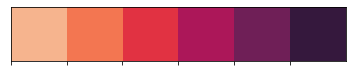

In [33]:
palette = sns.color_palette()
palette2 = sns.color_palette("rocket_r")
sns.palplot(palette2)

### Group by Noise Level

In [34]:
th = 0
laplacian_pcc_acc = pd.merge(laplacian2pcc,laplacian2acc,on=['test','laplacian_level'])
print(laplacian_pcc_acc['pcc'].min())
laplacian_pcc_acc['pcc'] = laplacian_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
laplacian_pcc_acc['acc'] = laplacian_pcc_acc['acc'].groupby([laplacian_pcc_acc['laplacian_level']]).transform('mean')
laplacian_pcc_acc = laplacian_pcc_acc[laplacian_pcc_acc['acc']>th]

gaussian_pcc_acc = pd.merge(gaussian2pcc,gaussian2acc,on=['test','gaussian_level'])
print(gaussian_pcc_acc['pcc'].min())
gaussian_pcc_acc['pcc'] = gaussian_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
gaussian_pcc_acc['acc'] = gaussian_pcc_acc['acc'].groupby([gaussian_pcc_acc['gaussian_level']]).transform('mean')
gaussian_pcc_acc = gaussian_pcc_acc[gaussian_pcc_acc['acc']>th]

biterror_pcc_acc = pd.merge(biterror2pcc[biterror2pcc['biterror1'] == biterror2pcc['biterror2']],
                            biterror2acc[biterror2acc['biterror1'] == biterror2acc['biterror2']],
                            on=['test','biterror1','biterror2'])
print(biterror_pcc_acc['pcc'].min())
biterror_pcc_acc['pcc'] = biterror_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
biterror_pcc_acc['acc'] = biterror_pcc_acc['acc'].groupby([biterror_pcc_acc['biterror1'],biterror_pcc_acc['biterror2']]).transform('mean')
biterror_pcc_acc = biterror_pcc_acc[biterror_pcc_acc['acc']>th]

df_final = pd.concat([biterror_pcc_acc[['pcc','acc']].assign(noise='biterror'),
                      gaussian_pcc_acc[['pcc','acc']].assign(noise='gaussian'),
                      laplacian_pcc_acc[['pcc','acc']].assign(noise='laplacian')]).reset_index(drop=True)
df_final

-0.24400962433647946
0.0028470776238113927
-0.38860433527351385
0.0028470776238113927
-0.5469957468465584
0.0028470776238113927


,pcc,acc,noise
0,0.986107,0.854948,biterror
1,0.989664,0.854948,biterror
2,0.991939,0.854948,biterror
3,1.004423,0.854948,biterror
4,0.991401,0.854948,biterror
...,...,...,...
252475,0.755125,0.724268,laplacian
252476,0.724763,0.724268,laplacian
252477,0.623717,0.724268,laplacian
252478,0.885035,0.724268,laplacian


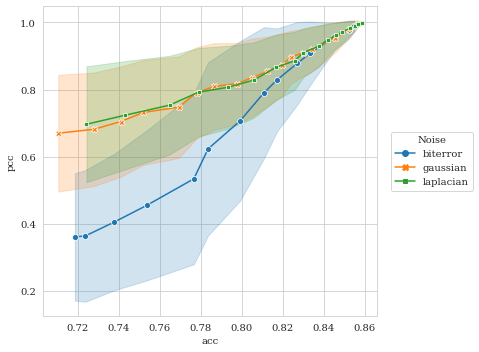

In [35]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"


plt.figure(figsize=(7,5))
ax = sns.lineplot(data=df_final, x="acc", y="pcc",hue="noise", style="noise",
    markers=True,dashes=False, ci='sd', err_style='band')
plt.legend(ncol=1, title='Noise',loc='center right', bbox_to_anchor=(1.3, 0.5)) # , bbox_to_anchor=(1.5, 0.5)
plt.tight_layout()

### Group by Accuracy

In [36]:
th = 0.70 * 100
high_th = 0.855 * 100
laplacian_pcc_acc = pd.merge(laplacian2pcc,laplacian2acc,on=['test','laplacian_level'])
print(laplacian_pcc_acc['pcc'].min())
laplacian_pcc_acc['pcc'] = laplacian_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
laplacian_pcc_acc['acc'] = laplacian_pcc_acc['acc'].apply(lambda x: np.floor(x*100*2/3+0.5)*1.5)
laplacian_pcc_acc = laplacian_pcc_acc[(laplacian_pcc_acc['acc']>th)&(laplacian_pcc_acc['acc']<high_th)]

gaussian_pcc_acc = pd.merge(gaussian2pcc,gaussian2acc,on=['test','gaussian_level'])
print(gaussian_pcc_acc['pcc'].min())
gaussian_pcc_acc['pcc'] = gaussian_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
gaussian_pcc_acc['acc'] = gaussian_pcc_acc['acc'].apply(lambda x: np.floor(x*100*2/3+5/6.0)*1.5-0.5)
gaussian_pcc_acc = gaussian_pcc_acc[(gaussian_pcc_acc['acc']>th)&(gaussian_pcc_acc['acc']<high_th)]

biterror_pcc_acc = pd.merge(biterror2pcc[biterror2pcc['biterror1'] == biterror2pcc['biterror2']],
                            biterror2acc[biterror2acc['biterror1'] == biterror2acc['biterror2']],
                            on=['test','biterror1','biterror2'])
print(biterror_pcc_acc['pcc'].min())
biterror_pcc_acc['pcc'] = biterror_pcc_acc['pcc'].transform('abs')
print(laplacian_pcc_acc['pcc'].min())
biterror_pcc_acc['acc'] = biterror_pcc_acc['acc'].apply(lambda x: np.floor(x*100*2/3+1/6.0)*1.5+0.5)
biterror_pcc_acc = biterror_pcc_acc[(biterror_pcc_acc['acc']>th)&(biterror_pcc_acc['acc']<high_th)]

df_final = pd.concat([biterror_pcc_acc[['pcc','acc']].assign(Noise='Bit error'),
                      gaussian_pcc_acc[['pcc','acc']].assign(Noise='Gaussian'),
                      laplacian_pcc_acc[['pcc','acc']].assign(Noise='Laplacian')]).reset_index(drop=True)
df_final

-0.24400962433647946
0.0028470776238113927
-0.38860433527351385
0.0028470776238113927
-0.5469957468465584
0.0028470776238113927


,pcc,acc,Noise
0,0.966012,84.5,Bit error
1,0.996862,84.5,Bit error
2,0.965615,84.5,Bit error
3,0.979517,84.5,Bit error
4,0.986839,84.5,Bit error
...,...,...,...
217759,0.755125,73.5,Laplacian
217760,0.724763,73.5,Laplacian
217761,0.623717,73.5,Laplacian
217762,0.885035,73.5,Laplacian


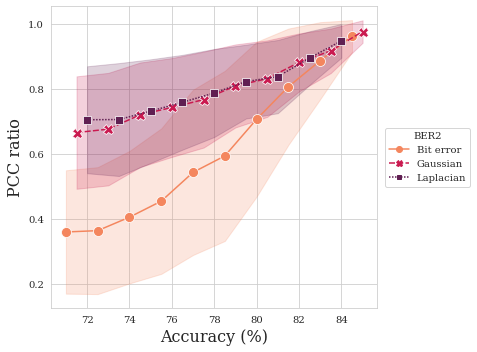

In [37]:
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"


plt.figure(figsize=(7,5))
ax = sns.lineplot(data=df_final, x="acc", y="pcc",hue="Noise", style="Noise",
    markers=True,markersize=10,dashes=True, ci='sd', err_style='band',palette=sns.color_palette("rocket_r", n_colors=3)) #palette=palette[2:3]+palette[:2]
ax.set_xlabel("Accuracy (%)",fontsize=16)
ax.set_ylabel("PCC ratio",fontsize=16)

plt.legend(ncol=1, title='BER2',loc='center right', bbox_to_anchor=(1.3, 0.5)) # , bbox_to_anchor=(1.5, 0.5)

plt.tight_layout()
plt.savefig(f'{output_path}/pcc_acc_noise.pdf', format='pdf')


In [38]:
# th = 0
# laplacian_pcc_acc = pd.merge(laplacian2pcc,laplacian2acc,on=['test','laplacian_level'])
# print(laplacian_pcc_acc['pcc'].min())
# laplacian_pcc_acc['pcc'] = laplacian_pcc_acc['pcc'].transform('abs')
# print(laplacian_pcc_acc['pcc'].min())
# laplacian_pcc_acc['acc'] = laplacian_pcc_acc['acc'].apply(lambda x: np.floor(x*100/2)*2+1)
# laplacian_pcc_acc = laplacian_pcc_acc[(laplacian_pcc_acc['acc']>th) & (laplacian_pcc_acc['acc']<86)]

# gaussian_pcc_acc = pd.merge(gaussian2pcc,gaussian2acc,on=['test','gaussian_level'])
# print(gaussian_pcc_acc['pcc'].min())
# gaussian_pcc_acc['pcc'] = gaussian_pcc_acc['pcc'].transform('abs')
# print(laplacian_pcc_acc['pcc'].min())
# gaussian_pcc_acc['acc'] = gaussian_pcc_acc['acc'].apply(lambda x: np.floor(x*100/2)*2+1)
# gaussian_pcc_acc = gaussian_pcc_acc[gaussian_pcc_acc['acc']>th]

# biterror_pcc_acc = pd.merge(biterror2pcc[biterror2pcc['biterror1'] == biterror2pcc['biterror2']],
#                             biterror2acc[biterror2acc['biterror1'] == biterror2acc['biterror2']],
#                             on=['test','biterror1','biterror2'])
# print(biterror_pcc_acc['pcc'].min())
# biterror_pcc_acc['pcc'] = biterror_pcc_acc['pcc'].transform('abs')
# print(laplacian_pcc_acc['pcc'].min())
# biterror_pcc_acc['acc'] = biterror_pcc_acc['acc'].apply(lambda x: np.floor(x*100/2)*2+1)
# biterror_pcc_acc = biterror_pcc_acc[biterror_pcc_acc['acc']>th]

# df_final = pd.concat([biterror_pcc_acc[['pcc','acc']].assign(noise='biterror'),
#                       gaussian_pcc_acc[['pcc','acc']].assign(noise='gaussian'),
#                       laplacian_pcc_acc[['pcc','acc']].assign(noise='laplacian')]).reset_index(drop=True)
# df_final

In [39]:
# import seaborn as sns
# sns.set_style("whitegrid")
# plt.rcParams["font.family"] = "serif"


# plt.figure(figsize=(7,5))
# ax = sns.lineplot(data=df_final, x="acc", y="pcc",hue="noise", style="noise",
#     markers=True,dashes=False, ci='sd', err_style='bars',palette=palette[2:3]+palette[:2])


# plt.figure(figsize=(7,5))
# ax = sns.catplot(x="acc", y="pcc", hue="noise", kind="box", data=df_final,
#                 height=5,aspect=7.0/5.0, legend=False,palette=palette[2:3]+palette[:2])

## Plot the inversion results

In [40]:
laplacian_pcc_acc = pd.concat([laplacian2pcc.groupby(['laplacian_level'])['pcc'].mean(),laplacian2acc.groupby(['laplacian_level'])['acc'].mean()],axis=1)
gaussian_pcc_acc = pd.concat([gaussian2pcc.groupby(['gaussian_level'])['pcc'].mean(),gaussian2acc.groupby(['gaussian_level'])['acc'].mean()],axis=1)
biterror_pcc_acc = pd.concat([biterror2pcc.groupby(['biterror1'])['pcc'].mean(),biterror2acc.groupby(['biterror1'])['acc'].mean()],axis=1)

In [41]:
# test2_set
plot1_indices = []
plot2_indices = []
current_label = -1
for i, target in enumerate(test1_set.targets):
    if target > current_label:
        current_label = target
        if target < 50:
            plot1_indices.append(i)
        else:
            plot2_indices.append(i)

plot1_dataset = torch.utils.data.Subset(test1_set, plot1_indices)
plot1_loader = torch.utils.data.DataLoader(plot1_dataset, batch_size=args.batch_size)

plot2_dataset = torch.utils.data.Subset(test1_set, plot2_indices)
plot2_loader = torch.utils.data.DataLoader(plot2_dataset, batch_size=args.batch_size)

In [42]:
acc_pt = 0.80
print(laplacian_pcc_acc.iloc[(laplacian_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]])
laplacian_level = laplacian_pcc_acc.index.values[(laplacian_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]]
print(gaussian_pcc_acc.iloc[(gaussian_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]])
gaussian_level = gaussian_pcc_acc.index.values[(gaussian_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]]
print(biterror_pcc_acc.iloc[(biterror_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]])
biterror = biterror_pcc_acc.index.values[(biterror_pcc_acc['acc']-acc_pt).abs().argsort().iloc[0]]

pcc    0.828284
acc    0.805905
Name: 0.012, dtype: float64
pcc    0.817898
acc    0.797855
Name: 0.018, dtype: float64
pcc    0.703011
acc    0.799193
Name: 0.0208333333333333, dtype: float64


In [43]:
def test_plot(classifier, inversion, device, data_loader, epoch, msg, biterror, gaussian_level, laplacian_level):
    classifier.eval()
    inversion.eval()
    plot = True
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # No defense
            classifier.module.fc[0].weight.data = ww1
            classifier.module.fc[0].bias.data[:] = bb1
            classifier.module.fc[2].weight.data = ww2
            classifier.module.fc[2].bias.data[:] = bb2
            prediction = classifier(data, release=True)
            rec_nodefense = inversion(prediction)
            
            # Laplacian
            f = ww1
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[0].weight.data = f_modify
            f = bb1
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[0].bias.data = f_modify
            f = ww2
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[2].weight.data = f_modify
            f = bb2
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[2].bias.data = f_modify
            prediction = classifier(data, release=True)
            rec_laplacian = inversion(prediction)
            
            # Gaussain
            f = ww1
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[0].weight.data = f_modify
            f = bb1
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[0].bias.data = f_modify
            f = ww2
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[2].weight.data = f_modify
            f = bb2
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[2].bias.data = f_modify
            prediction = classifier(data, release=True)
            rec_gaussian = inversion(prediction)
            
            # Bit error
            for i in range(ww1.size()[0]):
                f = ww1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[0].weight.data[i] = f_modify
            for i in range(bb1.size()[0]):
                f = bb1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[0].bias.data[i] = f_modify
            for i in range(ww2.size()[0]):
                f = ww2[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[2].weight.data[i] = f_modify
            for i in range(bb2.size()[0]):
                f = bb2[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[2].bias.data[i] = f_modify
            prediction = classifier(data, release=True)
            rec_biterror = inversion(prediction)
            
            if plot:
                truth = data[0:8]
                inv_n = rec_nodefense[0:8]
                inv_l = rec_laplacian[0:8]
                inv_g = rec_gaussian[0:8]
                inv_b = rec_biterror[0:8]
                out = torch.cat((truth, inv_n, inv_g, inv_l, inv_b))
                # for i in range(1):
                #     out[i * 16:i * 16 + 8] = inverse[i * 8:i * 8 + 8]
                #     out[i * 16 + 8:i * 16 + 16] = truth[i * 8:i * 8 + 8]
                vutils.save_image(out, '{}/recon_{}_{}.png'.format(output_path,msg.replace(" ", ""), epoch), normalize=False)
                plot = False
            break
    return 

test_plot(classifier, inversion, device, plot2_loader, epoch, 'comparison', biterror, gaussian_level, laplacian_level)


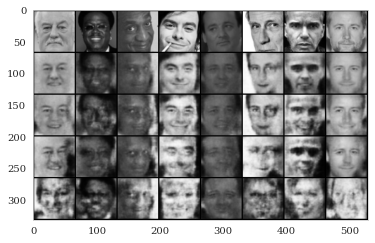

In [44]:
img = mpimg.imread('{}/recon_{}_{}.png'.format(output_path,'comparison'.replace(" ", ""), epoch))
imgplot = plt.imshow(img)
plt.grid(False)
plt.show()

In [45]:
classifier.module.fc[0].weight.data = copy.deepcopy(ww1)
classifier.module.fc[0].bias.data[:] = copy.deepcopy(bb1)
classifier.module.fc[2].weight.data = copy.deepcopy(ww2)
classifier.module.fc[2].bias.data[:] = copy.deepcopy(bb2)
# classifier_test(classifier, device, test2_loader)

## Explore Effect of Bit Error in Convolutional Layers

In [46]:
conv_biterror2acc_file = 'conv_biterror2acc.csv'
conv_biterror2pcc_file = 'conv_biterror2pcc.csv'

test_n = 0
conv_biterror2acc = pd.DataFrame(columns=['test','layer','biterror','acc'])
conv_biterror2pcc = pd.DataFrame(columns=['test','layer','biterror','idx','target','pcc'])

In [47]:
# set bit error list
bit_error_percent_list = np.logspace(-4,-10,7,base=2)
# bit_error_percent_list = np.logspace(-6,-7,1,base=2)
# bit_error_percent_list = sorted(np.append(bit_error_percent_list, [np.logspace(-5,-7,3,base=2) * 4 / 3, np.logspace(-5,-7,3,base=2) * 5 / 3]))
# bit_error_percent_list = np.append(bit_error_percent_list,0.07)
bit_error_n = len(bit_error_percent_list)
print(bit_error_percent_list, bit_error_n)

[0.0625     0.03125    0.015625   0.0078125  0.00390625 0.00195312
 0.00097656] 7


In [48]:
if os.path.exists(f'{output_path}/{conv_biterror2acc_file}'):
    conv_biterror2acc = pd.read_csv(f'{output_path}/{conv_biterror2acc_file}')
if os.path.exists(f'{output_path}/{conv_biterror2pcc_file}'):
    conv_biterror2pcc = pd.read_csv(f'{output_path}/{conv_biterror2pcc_file}')
    

for ntest in range(test_n):
    for num, biterror in enumerate(bit_error_percent_list):
        start_time = time.time() 
        for layer, (ww, bb) in enumerate([(conv1w,conv1b),(conv2w,conv2b),(conv3w,conv3b),(conv4w,conv4b)]): #
            
            ww, bb = copy.deepcopy(ww), copy.deepcopy(bb)
            
            for i in range(ww.size()[0]):
                f = ww[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.encoder[layer*4].weight.data[i] = f_modify

            for i in range(bb.size()[0]):
                f = bb[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.encoder[layer*4].bias.data[i] = f_modify
                
            
            # get accuracy for modified network
            tmpacc = classifier_test(classifier, device, test2_loader)
            conv_biterror2acc = conv_biterror2acc.append({'test': ntest, 'layer': layer, 'biterror': biterror, 'acc': tmpacc}, ignore_index=True)

            # get pcc similarity for modified network
            classifier.eval()
            inversion.eval()
            with torch.no_grad():
                for i, (data, target) in enumerate(pcc_dataset):
                    data = data.to(device)
                    prediction = classifier(data, release=True)
                    reconstruction = inversion(prediction)

                    vdata = data - torch.mean(data)
                    vreconstruction = reconstruction - torch.mean(reconstruction)
                    pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))

                    conv_biterror2pcc = conv_biterror2pcc.append({'test': ntest,'layer': layer,'biterror':biterror,'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)

            end_time = time.time()
            print("time:", end_time-start_time)

            conv_biterror2acc.to_csv(f'{output_path}/{conv_biterror2acc_file}', index=False)
            conv_biterror2pcc.to_csv(f'{output_path}/{conv_biterror2pcc_file}', index=False)
            
            # Change modified parameters back
            classifier.module.encoder[layer*4].weight.data[:] = ww
            classifier.module.encoder[layer*4].bias.data[:] = bb
        
        for layer, (ww, bb) in enumerate([(ww1,bb1),(ww2,bb2)]): 
            ww, bb = copy.deepcopy(ww), copy.deepcopy(bb)
            
            for i in range(ww.size()[0]):
                f = ww[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[layer*2].weight.data[i] = f_modify

            for i in range(bb.size()[0]):
                f = bb[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[layer*2].bias.data[i] = f_modify
                
            
            # get accuracy for modified network
            tmpacc = classifier_test(classifier, device, test2_loader)
            conv_biterror2acc = conv_biterror2acc.append({'test': ntest, 'layer': layer+4,'biterror': biterror, 'acc': tmpacc}, ignore_index=True)

            # get pcc similarity for modified network
            classifier.eval()
            inversion.eval()
            with torch.no_grad():
                for i, (data, target) in enumerate(pcc_dataset):
                    data = data.to(device)
                    prediction = classifier(data, release=True)
                    reconstruction = inversion(prediction)

                    vdata = data - torch.mean(data)
                    vreconstruction = reconstruction - torch.mean(reconstruction)
                    pcc = torch.sum(vdata*vreconstruction)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vreconstruction**2))

                    conv_biterror2pcc = conv_biterror2pcc.append({'test': ntest,'layer': layer+4,'biterror':biterror,'idx': i, 'target': target, 'pcc': pcc.item()}, ignore_index=True)

            end_time = time.time()
            print("time:", end_time-start_time)

            conv_biterror2acc.to_csv(f'{output_path}/{conv_biterror2acc_file}', index=False)
            conv_biterror2pcc.to_csv(f'{output_path}/{conv_biterror2pcc_file}', index=False)
            
            # Change modified parameters back
            classifier.module.fc[layer*2].weight.data[:] = ww
            classifier.module.fc[layer*2].bias.data[:] = bb
            
# classifier_test(classifier, device, test2_loader)

In [49]:
conv_biterror2pcc.groupby(['layer','biterror'])['pcc'].mean()

layer  biterror
0.0    0.000977    0.415416
       0.001953    0.393281
       0.003906    0.394809
       0.007812    0.395329
       0.015625    0.364677
       0.031250    0.334959
       0.062500    0.288993
1.0    0.000977    0.885005
       0.001953    0.883499
       0.003906    0.881222
       0.007812    0.878878
       0.015625    0.875680
       0.031250    0.849830
       0.062500    0.810206
2.0    0.000977    0.884721
       0.001953    0.883502
       0.003906    0.881081
       0.007812    0.874610
       0.015625    0.859207
       0.031250    0.827255
       0.062500    0.768131
3.0    0.000977    0.884490
       0.001953    0.883689
       0.003906    0.882282
       0.007812    0.878142
       0.015625    0.872259
       0.031250    0.860628
       0.062500    0.831135
4.0    0.000977    0.884073
       0.001953    0.882768
       0.003906    0.879861
       0.007812    0.876251
       0.015625    0.854701
       0.031250    0.776372
       0.062500    0.592679
5.0 

In [50]:
conv_biterror2acc.groupby(['layer','biterror'])['acc'].mean()

layer  biterror
0.0    0.000977    0.003645
       0.001953    0.003783
       0.003906    0.003691
       0.007812    0.003599
       0.015625    0.002584
       0.031250    0.003276
       0.062500    0.002307
1.0    0.000977    0.855271
       0.001953    0.854210
       0.003906    0.849412
       0.007812    0.841246
       0.015625    0.830634
       0.031250    0.769504
       0.062500    0.574302
2.0    0.000977    0.855825
       0.001953    0.853103
       0.003906    0.849550
       0.007812    0.838524
       0.015625    0.807935
       0.031250    0.715386
       0.062500    0.513956
3.0    0.000977    0.857070
       0.001953    0.856655
       0.003906    0.854487
       0.007812    0.849458
       0.015625    0.838431
       0.031250    0.824037
       0.062500    0.795709
4.0    0.000977    0.858178
       0.001953    0.856517
       0.003906    0.856424
       0.007812    0.852318
       0.015625    0.849227
       0.031250    0.845490
       0.062500    0.840231
5.0 

In [51]:
df_conv = pd.concat([conv_biterror2pcc.groupby(['layer','biterror'])['pcc'].mean(), conv_biterror2acc.groupby(['layer','biterror'])['acc'].mean()], axis=1).reset_index()
df_conv = df_conv[df_conv['layer']>0.1]

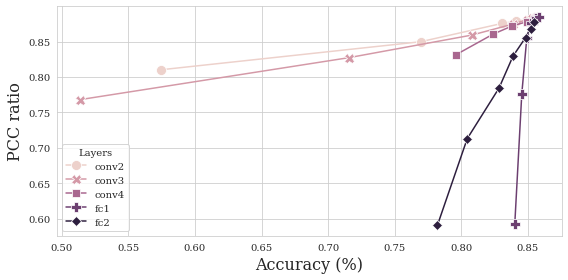

In [52]:
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"


plt.figure(figsize=(8,4))
ax = sns.lineplot(data=df_conv, x="acc", y="pcc",hue="layer", style="layer",
    markers=True,markersize=10, dashes=False, ci='sd', err_style='bars',legend=False)

ax.set_xlabel("Accuracy (%)",fontsize=16)
ax.set_ylabel("PCC ratio",fontsize=16)

plt.tight_layout()
plt.legend(title='Layers', loc='lower left', labels=['conv2', 'conv3', 'conv4', 'fc1', 'fc2'], prop={'size': 10})
plt.savefig(f'{output_path}/pcc_acc_cnnlayer.pdf', format='pdf')

In [53]:
biterror=0.0625

In [54]:
def test_plot(classifier, inversion, device, data_loader, epoch, msg, biterror, gaussian_level, laplacian_level):
    classifier.eval()
    inversion.eval()
    plot = True
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # No defense
            classifier.module.fc[0].weight.data = ww1
            classifier.module.fc[0].bias.data[:] = bb1
            classifier.module.fc[2].weight.data = ww2
            classifier.module.fc[2].bias.data[:] = bb2
            prediction = classifier(data, release=True)
            rec_nodefense = inversion(prediction)
            
            # Laplacian
            f = ww1
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[0].weight.data = f_modify
            f = bb1
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[0].bias.data = f_modify
            f = ww2
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[2].weight.data = f_modify
            f = bb2
            noise = torch.Tensor(np.random.laplace(loc=0.0, scale=1.0, size=f.size())).to(device)*laplacian_level
            f_modify = f + noise
            classifier.module.fc[2].bias.data = f_modify
            prediction = classifier(data, release=True)
            rec_laplacian = inversion(prediction)
            
            # Gaussain
            f = ww1
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[0].weight.data = f_modify
            f = bb1
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[0].bias.data = f_modify
            f = ww2
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[2].weight.data = f_modify
            f = bb2
            noise = torch.randn(f.size()).to(device)*gaussian_level
            f_modify = f + noise
            classifier.module.fc[2].bias.data = f_modify
            prediction = classifier(data, release=True)
            rec_gaussian = inversion(prediction)
            
            # Bit error
            for i in range(ww1.size()[0]):
                f = ww1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[0].weight.data[i] = f_modify
            for i in range(bb1.size()[0]):
                f = bb1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
                classifier.module.fc[0].bias.data[i] = f_modify
            # for i in range(ww2.size()[0]):
            #     f = ww2[i]
            #     f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
            #     classifier.module.fc[2].weight.data[i] = f_modify
            # for i in range(bb2.size()[0]):
            #     f = bb2[i]
            #     f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror), fixed_exp, nbits)
            #     classifier.module.fc[2].bias.data[i] = f_modify
            prediction = classifier(data, release=True)
            rec_biterror = inversion(prediction)
            
            if plot:
                truth = data[0:8]
                inv_n = rec_nodefense[0:8]
                inv_l = rec_laplacian[0:8]
                inv_g = rec_gaussian[0:8]
                inv_b = rec_biterror[0:8]
                out = torch.cat((truth, inv_n, inv_g, inv_l, inv_b))
                # for i in range(1):
                #     out[i * 16:i * 16 + 8] = inverse[i * 8:i * 8 + 8]
                #     out[i * 16 + 8:i * 16 + 16] = truth[i * 8:i * 8 + 8]
                vutils.save_image(out, '{}/recon_{}_{}.png'.format(output_path,msg.replace(" ", ""), epoch), normalize=False)
                plot = False
            break
    return 

# test_plot(classifier, inversion, device, plot2_loader, epoch, 'comparison', biterror, gaussian_level, laplacian_level)


In [55]:
classifier.module.fc[0].weight.data = copy.deepcopy(ww1)
classifier.module.fc[0].bias.data[:] = copy.deepcopy(bb1)
classifier.module.fc[2].weight.data = copy.deepcopy(ww2)
classifier.module.fc[2].bias.data[:] = copy.deepcopy(bb2)
# classifier_test(classifier, device, test2_loader)

In [56]:
# # Train inversion model
# best_recon_loss = 999
# for epoch in range(1, args.epochs + 1):
#     train(classifier, inversion, args.log_interval, device, train_loader, optimizer, epoch)
#     recon_loss = test(classifier, inversion, device, test1_loader, epoch, 'test1')
#     test(classifier, inversion, device, test2_loader, epoch, 'test2')

#     if recon_loss < best_recon_loss:
#         best_recon_loss = recon_loss
#         state = {
#             'epoch': epoch,
#             'model': inversion.state_dict(),
#             'optimizer': optimizer.state_dict(),
#             'best_recon_loss': best_recon_loss
#         }
#         torch.save(state, 'out/inversion.pth')
#         shutil.copyfile('out/recon_test1_{}.png'.format(epoch), 'out/best_test1.png')
#         shutil.copyfile('out/recon_test2_{}.png'.format(epoch), 'out/best_test2.png')

In [57]:
# args = parser.parse_args(['--num_workers', '0'])
# print("================================")
# print(args)
# print("================================")

# os.makedirs('out', exist_ok=True)

# use_cuda = not args.no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# kwargs = {'num_workers': args.num_workers, 'pin_memory': True} if use_cuda else {}

# torch.manual_seed(args.seed)


# celeba_transform = transforms.Compose([
#         transforms.Grayscale(),
#         transforms.ToTensor()
#     ])

# train_set = CelebA('.\\data\\celeba_64', transform=celeba_transform)


# train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True, **kwargs)

# for i_batch, sample_batched in enumerate(train_loader):
#     print(i_batch)
#     print(sample_batched[0].shape,sample_batched[1].shape)
    
# #     batch_size = sample_batched[0].size(0)
# #     im_size = sample_batched[0].size(2)
# #     grid_border_size = 2

#     grid = utils.make_grid(sample_batched[0])
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
#     break